In [1]:
from htm.bindings.sdr import SDR
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from datetime import datetime
import os
from htm.encoders.rdse import RDSE, RDSE_Parameters
import time
import traceback
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
inputSources = [
   "monthly_sp500_pca.csv",
   "weekly_dow_jones.csv",
   "weekly_nasdaq.csv",
   "weekly_sp500.csv",
   "monthly_vix_close.csv",
   "monthly_vix_high.csv",
   "monthly_vix_low.csv",
   "monthly_vix_open.csv",
   "daily_natural_gas.csv",
   "daily_oil_prices.csv",
   "value1_vix_close.csv",
   "value1_vix_high.csv",
   "value1_vix_low.csv",
   "value1_vix_open.csv",
   "monthly_gold_prices.csv"
]

In [3]:

config = {
    'enc': {
        "value" :
            {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (1638,),
        'potentialPct': 0.85,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.006,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'boostStrength': 3.0,
        'wrapAround': True,
        'seed': 1,
        'learn': False,
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000},
    'learnRows': 100,
    'reflexSize': 2048,
    'accuracyThreshold': 0.5,
    'controlThreshold': 4
}


In [4]:
class ReflexiveMemory:
  def __init__(self, reflexSize, dimensions_dense, dimensions_sparse_sp):
    self.acKey0 = None
    self.pairs = {}
    self.tableSize  = reflexSize
    self.dimensions_dense = dimensions_dense
    self.dimensions_sparse_sp = dimensions_sparse_sp

  def add(self, denseColumns):
    acKey1 = '-'.join(map(str, denseColumns.sparse))
    if(self.acKey0 != None):

      sequence = self.pairs.get(self.acKey0, {})
      sequence_data = sequence.get(acKey1, {
         "count": 0,
         "time": datetime.now()
      })
      if sequence_data["count"] < 256:
        sequence_data["count"] = sequence_data["count"] + 1
      sequence_data["time"] = datetime.now()

      if self.pairs.get(self.acKey0, None) is None:
        self.pairs[self.acKey0] = { acKey1: sequence_data }
      else:
        self.pairs[self.acKey0][acKey1] = sequence_data
        
      table_entries = 0
      oldKey1 = None
      oldKey2 = None
      oldTime = datetime.now()
      for key1, value1 in self.pairs.items():
        table_entries = table_entries + len(value1.items())
        for key2, value2 in value1.items():
          if value2['time'] < oldTime:
            oldKey1 = key1
            oldKey2 = key2
            oldTime = value2['time']
      if table_entries > self.tableSize:
        del self.pairs[oldKey1][oldKey2]
        if len(self.pairs[oldKey1].items()) == 0:
          del self.pairs[oldKey1]

    self.acKey0 = acKey1

  def predict(self, denseColumns):
    return_count = 0
    return_sdr = None

    acKey = '-'.join(map(str, denseColumns.sparse))
    sequences = self.pairs.get(acKey, {})
    for sequence_key, sequence_data in sequences.items():
      if sequence_data["count"] > return_count:
        return_count = sequence_data["count"]
        return_sdr = sequence_key

    if return_sdr is not None:
      tmp_sdr = SDR( self.dimensions_dense )
      tmp_sdr.sparse = list(map(int, return_sdr.split('-')))
      return_sdr = tmp_sdr
    else:
      return_count = None

    return return_count, return_sdr


In [5]:
class ControlHistory:
  def __init__(self):
    self.anomalyRM = []
    self.anomalyTM = []
    self.anomalyNU = []
    self.historyRM = []
    self.historyTM = []
    self.historyGT = []

  def anomalyScore(self, y, x):
      if np.count_nonzero(y) != 0:
          return 1 - np.count_nonzero((x & y)) / np.count_nonzero(y)
      return 1

  def add(self, denseColumns1, sp, tm, rm):

    if rm.acKey0 is not None:

      denseColumns0 = SDR( rm.dimensions_dense )
      denseColumns0.sparse = list(map(int, rm.acKey0.split('-')))

      tm.activateDendrites(True)
      predictiveCells = tm.getPredictiveCells()

      predictiveColumns = SDR( rm.dimensions_sparse_sp )
      predictiveColumns.sparse = list(set(sorted(list(np.where(predictiveCells.dense == 1)[0]))))

      reflexiveColumns = SDR( rm.dimensions_sparse_sp )
      reflexiveCount, denseReflexiveColumns = rm.predict(denseColumns0)
      if denseReflexiveColumns is not None:
        sp.compute(denseReflexiveColumns, False, reflexiveColumns)

      activeColumns0 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns0, False, activeColumns0)

      activeColumns1 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns1, False, activeColumns1)

      self.historyRM.append( reflexiveColumns.dense )
      self.historyTM.append( predictiveColumns.dense )
      self.historyGT.append( activeColumns1.dense )

      self.anomalyNU.append(tm.anomaly)
      self.anomalyRM.append( self.anomalyScore(activeColumns1.dense, reflexiveColumns.dense) )
      self.anomalyTM.append( self.anomalyScore(activeColumns1.dense, predictiveColumns.dense) )


In [6]:
class ControlUnit:
  def __init__(self, controlThreshold):
    self.anomalyCU = []
    self.historyCU = []
    self.countRMCU = 0
    self.controlThreshold = controlThreshold

  def compute(self, ch, rm):

    if rm.acKey0 is not None:

      rmin = -1-self.controlThreshold
      if (len(ch.anomalyRM) > self.controlThreshold) and (sum(ch.anomalyRM[rmin:-1]) > sum(ch.anomalyTM[rmin:-1])):
        self.anomalyCU.append( ch.anomalyTM[-1] )
        self.historyCU.append( ch.historyTM[-1] )
        self.countRMCU = self.countRMCU + 1
      else:
        self.anomalyCU.append( ch.anomalyRM[-1] )
        self.historyCU.append( ch.historyRM[-1] )


In [7]:
input_path = pathlib.Path('../datasets/numenta')
dataset_metrics = []

pbar = tqdm(total=len(inputSources))
for dataset in inputSources:

    tm_infer_tm = 0
    tm_infer_rm = 0

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
        
    scalarEncoderParams = RDSE_Parameters()
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoderParams.sparsity = config["enc"]["value"]["sparsity"]
    scalarEncoderParams.resolution = config["enc"]["value"]["resolution"]
    scalarEncoder = RDSE( scalarEncoderParams )
    encodingWidth = (scalarEncoder.size)

    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory( config['reflexSize'] , config['sp']['inputDimensions'], config['sp']['columnDimensions'])

    ch = ControlHistory()
    cu01 = ControlUnit( 1 )
    cu02 = ControlUnit( 2 )
    cu04 = ControlUnit( 4 )
    cu08 = ControlUnit( 8 )
    cu16 = ControlUnit( 16 )
    cu32 = ControlUnit( 32 )
    cu64 = ControlUnit( 64 )


    try:
        
        for count, record in enumerate(records):
            
            learn_sp = config['sp']['learn']
            learn_tm = config['tm']['learn']
            if count < config['learnRows']:
                learn_sp = True
                learn_tm = True

            consumption = float(record[1])
            consumptionBits = scalarEncoder.encode(consumption)
            encoding = SDR( consumptionBits )

            ch.add(encoding, sp, tm, rm)
            cu01.compute(ch, rm)
            cu02.compute(ch, rm)
            cu04.compute(ch, rm)
            cu08.compute(ch, rm)
            cu16.compute(ch, rm)
            cu32.compute(ch, rm)
            cu64.compute(ch, rm)


            tmp_tm = time.time()
            rm.add(encoding)
            rm.predict(encoding)
            tm_infer_rm = tm_infer_rm + (time.time() - tmp_tm)

            activeColumns = SDR( sp.getColumnDimensions() )

            tmp_tm = time.time()
            sp.compute(encoding, learn_sp, activeColumns)
            tm.compute(activeColumns, learn=learn_tm)
            tm_infer_tm = tm_infer_tm + (time.time() - tmp_tm)

    except Exception as e:
        print(traceback.format_exc())
        print(e)

    def match(y, x, idx1, ch, accuracyThreshold):
        n_samples = len(y)
        score1 = ch.anomalyScore(y[idx1], x[idx1])
        if score1 > (1 - accuracyThreshold):
            idx_closest = None
            score_closest = None
            for idx2 in range(n_samples):
                score2 = ch.anomalyScore(y[idx2], x[idx1])
                if score_closest is None or score_closest > score2:
                    score_closest = score2
                    idx_closest = idx2
            return idx_closest
        return idx1

    def calculateMetrics(config, cu, ch, tm_infer_rm, tm_infer_tm, suffix):

        metric = {}

        n_samples = len(ch.historyGT)

        Y_labels = list(range(n_samples))
        X_labels = [ match(ch.historyGT, cu.historyCU, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]

        total_infe_time = 0
        avg_infer_time_rm = tm_infer_rm / len(ch.anomalyRM)
        avg_infer_time_tm = tm_infer_tm / len(ch.anomalyTM)
        total_infe_time = total_infe_time + (avg_infer_time_rm * cu.countRMCU)
        total_infe_time = total_infe_time + (avg_infer_time_tm * (len(cu.anomalyCU) - cu.countRMCU))

        metric['rm-count-'+suffix] = cu.countRMCU
        metric['anomaly-samples-'+suffix] = len(cu.historyCU)
        metric['tm-count-'+suffix] = len(cu.historyCU) - cu.countRMCU

        metric['total-infer-time-'+suffix] = total_infe_time
        metric['infer-time-'+suffix] = total_infe_time / len(cu.anomalyCU)
        metric['accuracy-'+suffix] = accuracy_score(Y_labels, X_labels)

        X_labels = [ match(ch.historyGT, ch.historyTM, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]
        metric['accuracy-improvement-'+suffix] = metric['accuracy-'+suffix] - accuracy_score(Y_labels, X_labels)
        metric['infer-speedup-'+suffix] = 1 - (total_infe_time / tm_infer_tm)

        return metric

    metric = {}
    metric['dataset'] = dataset
    metric.update( calculateMetrics(config, cu01, ch, tm_infer_rm, tm_infer_tm, 'cu01') )
    metric.update( calculateMetrics(config, cu02, ch, tm_infer_rm, tm_infer_tm, 'cu02') )
    metric.update( calculateMetrics(config, cu04, ch, tm_infer_rm, tm_infer_tm, 'cu04') )
    metric.update( calculateMetrics(config, cu08, ch, tm_infer_rm, tm_infer_tm, 'cu08') )
    metric.update( calculateMetrics(config, cu16, ch, tm_infer_rm, tm_infer_tm, 'cu16') )
    metric.update( calculateMetrics(config, cu32, ch, tm_infer_rm, tm_infer_tm, 'cu32') )
    metric.update( calculateMetrics(config, cu64, ch, tm_infer_rm, tm_infer_tm, 'cu64') )

    dataset_metrics.append(metric)
    pbar.update(1)
    # break

pbar.close()

100%|██████████| 15/15 [07:31<00:00, 30.11s/it]


In [8]:
df = pd.DataFrame(dataset_metrics)
df.to_csv('metrics.csv', index=False)

In [9]:
table_1_features = ['dataset'] + [v for v in df.columns if 'accuracy-cu' in v]
df[table_1_features]

,dataset,accuracy-cu01,accuracy-cu02,accuracy-cu04,accuracy-cu08,accuracy-cu16,accuracy-cu32,accuracy-cu64
0,monthly_sp500_pca.csv,0.367459,0.390615,0.404631,0.408897,0.407069,0.408897,0.404631
1,weekly_dow_jones.csv,0.027417,0.033670,0.038480,0.039442,0.039442,0.038961,0.037518
2,weekly_nasdaq.csv,0.199038,0.214904,0.218750,0.219231,0.219231,0.219231,0.211058
3,weekly_sp500.csv,0.312830,0.337338,0.345026,0.346949,0.345988,0.345026,0.340221
4,monthly_vix_close.csv,0.886173,0.938025,0.961975,0.967407,0.967901,0.967901,0.967901
5,monthly_vix_high.csv,0.889630,0.929136,0.945926,0.949877,0.948889,0.950617,0.950370
6,monthly_vix_low.csv,0.921728,0.959259,0.976296,0.979012,0.978765,0.979506,0.979506
7,monthly_vix_open.csv,0.840988,0.905679,0.939506,0.948395,0.950123,0.949383,0.949136
8,daily_natural_gas.csv,0.978268,0.981200,0.985857,0.988617,0.991204,0.994136,0.995516
9,daily_oil_prices.csv,0.976506,0.984578,0.989880,0.992771,0.993614,0.993855,0.993855


In [10]:
table_2_features = ['dataset'] + [v for v in df.columns if 'total-infer-time' in v]
df[table_2_features]

,dataset,total-infer-time-cu01,total-infer-time-cu02,total-infer-time-cu04,total-infer-time-cu08,total-infer-time-cu16,total-infer-time-cu32,total-infer-time-cu64
0,monthly_sp500_pca.csv,0.246394,0.178700,0.134083,0.109159,0.103929,0.105159,0.112236
1,weekly_dow_jones.csv,0.512881,0.420595,0.338836,0.279107,0.233087,0.210811,0.215707
2,weekly_nasdaq.csv,0.408801,0.305805,0.237656,0.205585,0.190783,0.186466,0.196026
3,weekly_sp500.csv,0.295625,0.216720,0.175776,0.164388,0.162490,0.165744,0.174421
4,monthly_vix_close.csv,0.532573,0.309832,0.178074,0.137853,0.135912,0.135912,0.138686
5,monthly_vix_high.csv,0.600268,0.351932,0.196802,0.148747,0.138749,0.138749,0.143587
6,monthly_vix_low.csv,0.392322,0.251545,0.159794,0.126259,0.121663,0.119620,0.122344
7,monthly_vix_open.csv,0.587632,0.345659,0.197752,0.143602,0.136794,0.137723,0.140508
8,daily_natural_gas.csv,0.372252,0.344555,0.305735,0.260417,0.214164,0.171545,0.136359
9,daily_oil_prices.csv,0.633929,0.493181,0.383335,0.318063,0.289278,0.284368,0.285524


In [11]:
table_3_features = ['dataset'] + [v for v in df.columns if 'infer-time' in v and 'total' not in v]
df[table_3_features]

,dataset,infer-time-cu01,infer-time-cu02,infer-time-cu04,infer-time-cu08,infer-time-cu16,infer-time-cu32,infer-time-cu64
0,monthly_sp500_pca.csv,0.000150,0.000109,0.000082,0.000067,0.000063,0.000064,0.000068
1,weekly_dow_jones.csv,0.000247,0.000202,0.000163,0.000134,0.000112,0.000101,0.000104
2,weekly_nasdaq.csv,0.000197,0.000147,0.000114,0.000099,0.000092,0.000090,0.000094
3,weekly_sp500.csv,0.000142,0.000104,0.000084,0.000079,0.000078,0.000080,0.000084
4,monthly_vix_close.csv,0.000131,0.000077,0.000044,0.000034,0.000034,0.000034,0.000034
5,monthly_vix_high.csv,0.000148,0.000087,0.000049,0.000037,0.000034,0.000034,0.000035
6,monthly_vix_low.csv,0.000097,0.000062,0.000039,0.000031,0.000030,0.000030,0.000030
7,monthly_vix_open.csv,0.000145,0.000085,0.000049,0.000035,0.000034,0.000034,0.000035
8,daily_natural_gas.csv,0.000064,0.000059,0.000053,0.000045,0.000037,0.000030,0.000024
9,daily_oil_prices.csv,0.000076,0.000059,0.000046,0.000038,0.000035,0.000034,0.000034


In [12]:
table_4_features = ['dataset'] + [v for v in df.columns if 'accuracy-improvement' in v]
df[table_4_features]

,dataset,accuracy-improvement-cu01,accuracy-improvement-cu02,accuracy-improvement-cu04,accuracy-improvement-cu08,accuracy-improvement-cu16,accuracy-improvement-cu32,accuracy-improvement-cu64
0,monthly_sp500_pca.csv,-0.040829,-0.017672,-0.003656,0.000609,-0.001219,0.000609,-0.003656
1,weekly_dow_jones.csv,-0.012025,-0.005772,-0.000962,0.000000,0.000000,-0.000481,-0.001924
2,weekly_nasdaq.csv,-0.021635,-0.005769,-0.001923,-0.001442,-0.001442,-0.001442,-0.009615
3,weekly_sp500.csv,-0.032677,-0.008169,-0.000481,0.001442,0.000481,-0.000481,-0.005286
4,monthly_vix_close.csv,-0.081975,-0.030123,-0.006173,-0.000741,-0.000247,-0.000247,-0.000247
5,monthly_vix_high.csv,-0.061728,-0.022222,-0.005432,-0.001481,-0.002469,-0.000741,-0.000988
6,monthly_vix_low.csv,-0.059012,-0.021481,-0.004444,-0.001728,-0.001975,-0.001235,-0.001235
7,monthly_vix_open.csv,-0.108395,-0.043704,-0.009877,-0.000988,0.000741,0.000000,-0.000247
8,daily_natural_gas.csv,-0.017420,-0.014488,-0.009831,-0.007071,-0.004484,-0.001552,-0.000172
9,daily_oil_prices.csv,-0.016506,-0.008434,-0.003133,-0.000241,0.000602,0.000843,0.000843


In [13]:
table_5_features = ['dataset'] + [v for v in df.columns if 'infer-speedup' in v]
df[table_5_features]

,dataset,infer-speedup-cu01,infer-speedup-cu02,infer-speedup-cu04,infer-speedup-cu08,infer-speedup-cu16,infer-speedup-cu32,infer-speedup-cu64
0,monthly_sp500_pca.csv,0.587611,0.700911,0.775585,0.817300,0.826055,0.823995,0.812150
1,weekly_dow_jones.csv,0.276570,0.406741,0.522065,0.606313,0.671226,0.702646,0.695741
2,weekly_nasdaq.csv,0.500060,0.626018,0.709361,0.748582,0.766683,0.771963,0.760272
3,weekly_sp500.csv,0.590168,0.699556,0.756317,0.772105,0.774736,0.770225,0.758196
4,monthly_vix_close.csv,0.571240,0.750563,0.856637,0.889018,0.890581,0.890581,0.888348
5,monthly_vix_high.csv,0.579977,0.753745,0.862293,0.895918,0.902914,0.902914,0.899529
6,monthly_vix_low.csv,0.508874,0.685104,0.799963,0.841943,0.847696,0.850254,0.846844
7,monthly_vix_open.csv,0.571707,0.748068,0.855870,0.895336,0.900298,0.899621,0.897592
8,daily_natural_gas.csv,0.105578,0.172127,0.265400,0.374286,0.485421,0.587824,0.672366
9,daily_oil_prices.csv,0.408946,0.540175,0.642591,0.703449,0.730287,0.734865,0.733788


In [14]:
table_6_features = ['dataset'] + sorted(list(set(df.columns) - (set(table_1_features) | set(table_2_features) | set(table_3_features) | set(table_4_features) | set(table_5_features))))
df[table_6_features]

,dataset,anomaly-samples-cu01,anomaly-samples-cu02,anomaly-samples-cu04,anomaly-samples-cu08,anomaly-samples-cu16,anomaly-samples-cu32,anomaly-samples-cu64,rm-count-cu01,rm-count-cu02,...,rm-count-cu16,rm-count-cu32,rm-count-cu64,tm-count-cu01,tm-count-cu02,tm-count-cu04,tm-count-cu08,tm-count-cu16,tm-count-cu32,tm-count-cu64
0,monthly_sp500_pca.csv,1641,1641,1641,1641,1641,1641,1641,1141,1361,...,1604,1600,1577,500,280,135,54,37,41,64
1,weekly_dow_jones.csv,2079,2079,2079,2079,2079,2079,2079,801,1178,...,1944,2035,2015,1278,901,567,323,135,44,64
2,weekly_nasdaq.csv,2080,2080,2080,2080,2080,2080,2080,1326,1660,...,2033,2047,2016,754,420,199,95,47,33,64
3,weekly_sp500.csv,2081,2081,2081,2081,2081,2081,2081,1570,1861,...,2061,2049,2017,511,220,69,27,20,32,64
4,monthly_vix_close.csv,4050,4050,4050,4050,4050,4050,4050,2558,3361,...,3988,3988,3978,1492,689,214,69,62,62,72
5,monthly_vix_high.csv,4050,4050,4050,4050,4050,4050,4050,2570,3340,...,4001,4001,3986,1480,710,229,80,49,49,64
6,monthly_vix_low.csv,4050,4050,4050,4050,4050,4050,4050,2388,3215,...,3978,3990,3974,1662,835,296,99,72,60,76
7,monthly_vix_open.csv,4050,4050,4050,4050,4050,4050,4050,2535,3317,...,3992,3989,3980,1515,733,255,80,58,61,70
8,daily_natural_gas.csv,5798,5798,5798,5798,5798,5798,5798,798,1301,...,3669,4443,5082,5000,4497,3792,2969,2129,1355,716
9,daily_oil_prices.csv,8300,8300,8300,8300,8300,8300,8300,4556,6018,...,8136,8187,8175,3744,2282,1141,463,164,113,125


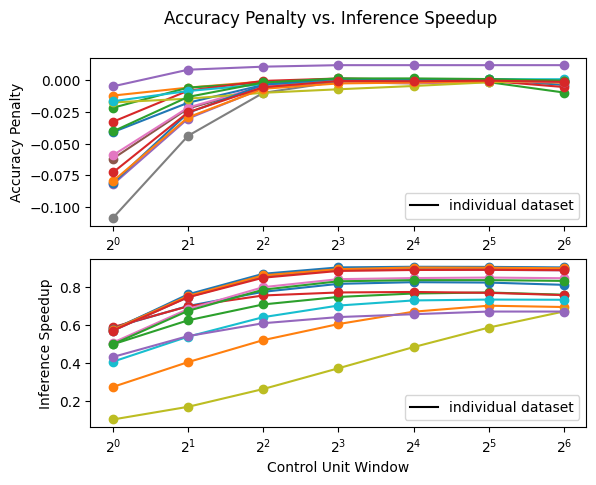

In [18]:
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accuracy Penalty vs. Inference Speedup')

# ax1.set_xlabel("Control Unit Window")
ax1.set_ylabel("Accuracy Penalty")
ax1.set_xscale('log', base=2) 

columns = [v for v in df.columns if 'accuracy-improvement-cu' in v]
for row in df[columns].values:
    ax1.plot([int(v.lstrip('accuracy-improvement-cu')) for v in columns], row, label='Line 1', marker='o')
item1 = Line2D([0], [0], label='individual dataset', color='k')
ax1.legend(handles=[item1], loc = 'lower right')


ax2.set_xlabel("Control Unit Window")
ax2.set_ylabel("Inference Speedup")
ax2.set_xscale('log', base=2) 

columns = [v for v in df.columns if 'infer-speedup-cu' in v]
for row in df[columns].values:
    ax2.plot([int(v.lstrip('infer-speedup-cu')) for v in columns], row, marker='o')
item1 = Line2D([0], [0], label='individual dataset', color='k')
ax2.legend(handles=[item1], loc = 'lower right')

fig.show()